# Import Libraries 

In [31]:
import os
import json

import gc

import albumentations as albu
import cv2
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate,BatchNormalization,LeakyReLU,concatenate
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import multiprocessing
from matplotlib import pyplot as plt
num_cores = multiprocessing.cpu_count()

In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)
num_cores = multiprocessing.cpu_count()
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=8,
    inter_op_parallelism_threads=8,
    allow_soft_placement=True,device_count = {'CPU' : 1, 'GPU' : 1})

# Load Dataset

In [3]:
train_df = pd.read_csv('C:\\Users\\abasd\\OneDrive - Coventry University\\Masters\\MSc thesis\\Code\\cloud_dataset\\train.csv')
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(22184, 5)


Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2  0011165.jpg_Gravel                                                NaN   
3   0011165.jpg_Sugar                                                NaN   
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   

       ImageId ClassId  hasMask  
0  0011165.jpg    Fish     True  
1  0011165.jpg  Flower     True  
2  0011165.jpg  Gravel    False  
3  0011165.jpg   Sugar    False  
4  002be4f.jpg    Fish     True

In [4]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(5546, 2)


ImageId  hasMask
821   24dd99c.jpg        4
1885  562f80a.jpg        4
3260  944f10b.jpg        4
1872  55b539f.jpg        4
4464  cdf7242.jpg        4

In [5]:
sub_df = pd.read_csv('C:\\Users\\abasd\\OneDrive - Coventry University\\Masters\\MSc thesis\\Code\\cloud_dataset\\sample_submission.csv')
sub_df['ImageId'] = sub_df['Image_Label'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

# Helper Functions

In [6]:
def np_resize(img, input_shape):
    """
    Reshape a numpy array, which is input_shape=(height, width), 
    as opposed to input_shape=(width, height) for cv2
    """
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles
## the function below to plot the training and validation accuracy 

def plot(history,title):
    acc = history.history['accuracy']
    #acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    #val_acc = history.history['val_accuracy']

    plt.plot(epochs, acc, 'y', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    return plt

#plot the training and validation accuracy and loss at each epoch

def plot_loss(history,title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return plt
#Training and validation dice loss
def plot_dice_loss(history,title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return plt
def visualize(image, mask, mask_prediction):
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    f, ax = plt.subplots(2, 5, figsize=(24,8))

    ax[0, 0].imshow(image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
    
    ax[1, 0].imshow(image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(mask_prediction[:, :, i])
        ax[1, i + 1].set_title(f'Prediction {class_dict[i]}', fontsize=fontsize)

In [28]:
def visualize(image, mask, mask_prediction):
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    f, ax = plt.subplots(2, 5, figsize=(24,8))

    ax[0, 0].imshow(image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
    
    ax[1, 0].imshow(image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(mask_prediction[:, :, i])
        ax[1, i + 1].set_title(f'Prediction {class_dict[i]}', fontsize=fontsize)

# Evaluation metrices 

In [8]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

# DataGenerator classes 

In [ ]:
## this DataGenerator was adapted from keras website and a kaggle kernel and the reference is available in the report

In [9]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='C:\\Users\\abasd\\OneDrive - Coventry University\\Masters\\MSc thesis\\Code\\cloud_dataset\\train_images',
                 
                 batch_size=4, dim=(1400, 2100), n_channels=3, reshape=None,
                 augment=False, n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.augment = augment
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()
        np.random.seed(self.random_state)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            #######
            y = tf.cast(y, tf.float64)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_rgb(img_path)
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            
            # Store samples
            X[i,] = img #cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).reshape((img.shape[0],img.shape[1],1))

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks
            #print(y)
        #y = tf.cast(y, tf.float32)

        return y
    #assert os.path.exists(that_path)
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img
    
    def __random_transform(self, img, masks):
        composition = albu.Compose([
            albu.HorizontalFlip(),
            albu.VerticalFlip(),
            albu.ShiftScaleRotate(rotate_limit=45, shift_limit=0.15, scale_limit=0.15)
        ])
        
        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(
                img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch
    
    def getitem(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            y = tf.cast(y, tf.float32)
            
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')

# Prepare data for model using DataGenerator class

In [10]:
input_shape=(128, 256,3)
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [76]:
BATCH_SIZE = 4

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=2019, test_size=0.2
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    reshape=(128, 256),
    augment=True,
    n_channels=3,
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    reshape=(128, 256),
    augment=False,
    n_channels=3,
    n_classes=4
)

check_generator = DataGenerator(
    val_idx[0:10], 
    df=mask_count_df, 
    mode='predict',
    shuffle=False,
    reshape=(128, 256),
    augment=False,
    n_channels=3,
    n_classes=4,
    batch_size=4,
)

In [27]:
# check out the shapes
x, y = train_generator.__getitem__(0)
print(x.shape, y.shape)
print(x.dtype, y.dtype)

(4, 128, 256, 3) (4, 128, 256, 4)
float64 <dtype: 'float64'>


# Models 

## Useful blocks to build netwrok

In [ ]:
# parts of this part was addressed from github repo https://github.com/bnsreenu/python_for_microscopists

In [13]:
##############################################################
'''
Useful blocks to build Unet
conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)
'''


def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).
    
    1. conv - BN - Activation - conv - BN - Activation 
                                          - shortcut  - BN - shortcut+BN
                                          
    2. conv - BN - Activation - conv - BN   
                                     - shortcut  - BN - shortcut+BN - Activation                                     
    
    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

## 1:Original U-Net

In [14]:
def UNet(input_shape,name,NUM_CLASSES=4, dropout_rate=0.0, batch_norm=True):
    '''
    UNet, 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    

    inputs = layers.Input(input_shape, dtype=tf.float64)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
   
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
   
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
   
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)  #Change to softmax for multichannel

    # Model 
    model = models.Model(inputs, conv_final, name=name)
    print(model.summary())
    return model

## 2:Attention_Unet

In [15]:
def Attention_UNet(input_shape, NUM_CLASSES=4, dropout_rate=0.02, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float64)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model

## 3:Attention Residual_Unet

In [16]:
def Attention_ResUNet(input_shape, NUM_CLASSES=4, dropout_rate=0.02, batch_norm=True):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float64)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

# Compile and train models

In [17]:
from keras_radam import RAdam

In [18]:
input_shape=(128, 256,3)
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

## Compiling and training U_Net

In [19]:
UNet = UNet(input_shape,"Unet", NUM_CLASSES=4, dropout_rate=0.0, batch_norm=True)
UNet.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 256, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

### UNet evaluation with Dice Coefficient  as evaluation metrices

In [21]:
checkpoint = ModelCheckpoint('UNet.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=ES_PATIENCE,
                   restore_best_weights=True,
                   verbose=1)

rlrop = ReduceLROnPlateau(monitor='val_loss',
                          mode='min',
                          patience=RLROP_PATIENCE,
                          factor=DECAY_DROP,
                          min_lr=1e-6,
                          verbose=1)

UNet.compile(optimizer=RAdam(learning_rate=0.0002), loss=bce_dice_loss, metrics=[dice_coef])
UNet.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 256, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

In [22]:
%%time
#checkpoint = ModelCheckpoint('model_0EFU7.h5', save_best_only=True)

history_UNet = UNet.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, es, rlrop],
    epochs=30
)

Epoch 1/30
1109/1109 [==============================] - 499s 438ms/step - loss: 1.3411 - dice_coef: 0.3206 - val_loss: 1.4524 - val_dice_coef: 0.3369
Epoch 2/30
1109/1109 [==============================] - 482s 434ms/step - loss: 1.2649 - dice_coef: 0.3448 - val_loss: 1.2142 - val_dice_coef: 0.3905
Epoch 3/30
1109/1109 [==============================] - 489s 441ms/step - loss: 1.2127 - dice_coef: 0.3527 - val_loss: 1.2605 - val_dice_coef: 0.4074
Epoch 4/30
1109/1109 [==============================] - 482s 435ms/step - loss: 1.1624 - dice_coef: 0.3609 - val_loss: 1.1540 - val_dice_coef: 0.4294
Epoch 5/30
1109/1109 [==============================] - 472s 426ms/step - loss: 1.1246 - dice_coef: 0.3647 - val_loss: 1.0818 - val_dice_coef: 0.4099
Epoch 6/30
1109/1109 [==============================] - 472s 426ms/step - loss: 1.0910 - dice_coef: 0.3688 - val_loss: 1.0701 - val_dice_coef: 0.4030
Epoch 7/30
1109/1109 [==============================] - 457s 412ms/step - loss: 1.0635 - dice_coef: 

Text(0.5, 1.0, 'training and validation dice_coef with UNet')

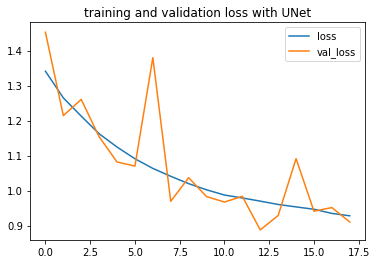

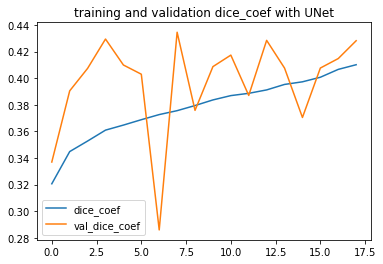

In [23]:
with open('history_UNet.json', 'w') as f:
    json.dump(str(history_UNet.history), f)

history_df = pd.DataFrame(history_UNet.history)
plt=history_df[['loss', 'val_loss']].plot()
plt.set_title("training and validation loss with UNet")
plt1=history_df[['dice_coef', 'val_dice_coef']].plot()
plt1.set_title("training and validation dice_coef with UNet")

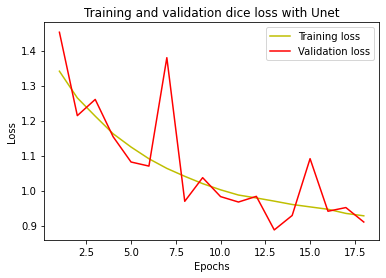

<module 'matplotlib.pyplot' from 'C:\\Users\\abasd\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [31]:
plot_dice_loss(history_UNet,'Training and validation dice loss with Unet')

In [64]:
jc = history_UNet.history['dice_coef']
#acc = history.history['accuracy']
val_jc = history_UNet.history['val_dice_coef']
#val_acc = history.history['val_accuracy']
#epochs = range(1, len(loss) + 1)

plt.plot(epochs, jc, 'y', label='Training Jacard Coeff.')
plt.plot(epochs, val_jc, 'b', label='Validation Jacard Coeff.')
plt.title('Training and validation Jacard')
plt.xlabel('Epochs')
plt.ylabel('Jacard Coefficient')
plt.legend()
plt.show()

### UNet evaluation with IoU as evaluation metrices

In [25]:

UNet.compile(optimizer=RAdam(learning_rate=0.0002), loss=[jacard_coef_loss], metrics=[jacard_coef])
UNet.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 256, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

In [26]:
%%time
#checkpoint = ModelCheckpoint('model_0EFU7.h5', save_best_only=True)

history_UNet1 = UNet.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, es, rlrop],
    epochs=30
)

Epoch 1/30
1109/1109 [==============================] - 485s 431ms/step - loss: -0.2596 - jacard_coef: 0.2596 - val_loss: -0.2823 - val_jacard_coef: 0.2823
Epoch 2/30
1109/1109 [==============================] - 478s 431ms/step - loss: -0.2661 - jacard_coef: 0.2661 - val_loss: -0.2960 - val_jacard_coef: 0.2960
Epoch 3/30
1109/1109 [==============================] - 476s 429ms/step - loss: -0.2713 - jacard_coef: 0.2713 - val_loss: -0.2730 - val_jacard_coef: 0.2730
Epoch 4/30
1109/1109 [==============================] - 477s 430ms/step - loss: -0.2721 - jacard_coef: 0.2721 - val_loss: -0.2326 - val_jacard_coef: 0.2326
Epoch 5/30
1109/1109 [==============================] - 480s 432ms/step - loss: -0.2777 - jacard_coef: 0.2777 - val_loss: -0.2998 - val_jacard_coef: 0.2998
Epoch 6/30
1109/1109 [==============================] - 479s 431ms/step - loss: -0.2830 - jacard_coef: 0.2830 - val_loss: -0.2260 - val_jacard_coef: 0.2260
Epoch 7/30
1109/1109 [==============================] - 477s 430

In [54]:
loss = history_UNet1.history['loss']
val_loss = history_UNet1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation jacard loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### UNet evaluation with accuracy as evaluation metrices

In [27]:
UNet.compile(optimizer=RAdam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])
UNet.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 256, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

In [28]:
%%time
#checkpoint = ModelCheckpoint('model_0EFU7.h5', save_best_only=True)

history_UNet2 = UNet.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, es, rlrop],
    epochs=30
)

Epoch 1/30
1109/1109 [==============================] - 491s 436ms/step - loss: 0.7986 - accuracy: 0.5615 - val_loss: 0.5804 - val_accuracy: 0.5282
Epoch 2/30
1109/1109 [==============================] - 479s 432ms/step - loss: 0.6631 - accuracy: 0.5573 - val_loss: 0.5758 - val_accuracy: 0.5381
Epoch 3/30
1109/1109 [==============================] - 480s 433ms/step - loss: 0.6506 - accuracy: 0.5459 - val_loss: 0.5947 - val_accuracy: 0.4889
Epoch 4/30
1109/1109 [==============================] - 480s 432ms/step - loss: 0.6452 - accuracy: 0.5290 - val_loss: 0.5647 - val_accuracy: 0.4682
Epoch 5/30
1109/1109 [==============================] - 478s 431ms/step - loss: 0.6423 - accuracy: 0.5132 - val_loss: 0.6900 - val_accuracy: 0.4670
Epoch 6/30
1109/1109 [==============================] - 476s 430ms/step - loss: 0.6369 - accuracy: 0.5077 - val_loss: 0.6324 - val_accuracy: 0.4221
Epoch 7/30
1109/1109 [==============================] - 474s 427ms/step - loss: 0.6336 - accuracy: 0.5028 - val_

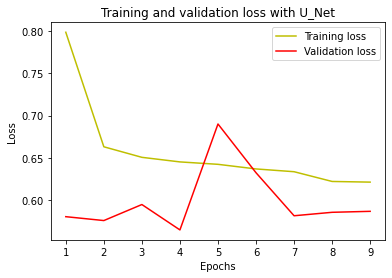

<module 'matplotlib.pyplot' from 'C:\\Users\\abasd\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [37]:
plot_loss(history_UNet2,'Training and validation loss with U_Net')

In [67]:
plot(history_UNet2,'Training and validation Accuracy with Unet')

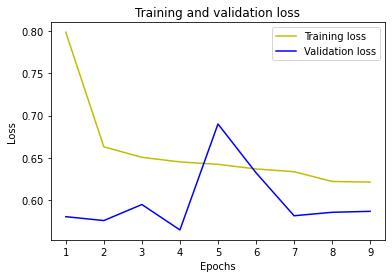

In [58]:
#plot the training and validation accuracy and loss at each epoch
loss = history_UNet2.history['loss']
val_loss = history_UNet2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

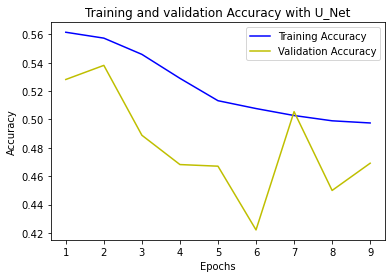

In [57]:
acc = history_UNet2.history['accuracy']
#acc = history.history['accuracy']
val_acc = history_UNet2.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation Accuracy')
plt.title('Training and validation Accuracy with U_Net')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Compile and train Attention_UNet 

### Attention_UNet evaluation with Dice Coefficient  as evaluation metrices

In [19]:
Attention_UNet = Attention_UNet(input_shape, NUM_CLASSES=4, dropout_rate=0.0, batch_norm=True)
Attention_UNet.summary()

Model: "Attention_UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 256, 64) 0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [20]:
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [21]:
checkpoint = ModelCheckpoint('Attention_UNet.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=ES_PATIENCE,
                   restore_best_weights=True,
                   verbose=1)

rlrop = ReduceLROnPlateau(monitor='val_loss',
                          mode='min',
                          patience=RLROP_PATIENCE,
                          factor=DECAY_DROP,
                          min_lr=1e-6,
                          verbose=1)

Attention_UNet.compile(optimizer=RAdam(learning_rate=0.0002), loss=bce_dice_loss, metrics=[dice_coef])
Attention_UNet.summary()

Model: "Attention_UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 256, 64) 0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [22]:
%%time
#checkpoint = ModelCheckpoint('model_0EFU7.h5', save_best_only=True)

history_Attention_UNet = Attention_UNet.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, es, rlrop],
    epochs=30
)

Epoch 1/30
1109/1109 [==============================] - 531s 455ms/step - loss: 1.3400 - dice_coef: 0.3213 - val_loss: 1.3968 - val_dice_coef: 0.4144
Epoch 2/30
1109/1109 [==============================] - 501s 452ms/step - loss: 1.2689 - dice_coef: 0.3426 - val_loss: 1.1967 - val_dice_coef: 0.4260
Epoch 3/30
1109/1109 [==============================] - 500s 450ms/step - loss: 1.2107 - dice_coef: 0.3541 - val_loss: 1.3076 - val_dice_coef: 0.3210
Epoch 4/30
1109/1109 [==============================] - 504s 455ms/step - loss: 1.1674 - dice_coef: 0.3582 - val_loss: 1.2680 - val_dice_coef: 0.3874
Epoch 5/30
1109/1109 [==============================] - 509s 459ms/step - loss: 1.1266 - dice_coef: 0.3635 - val_loss: 1.1226 - val_dice_coef: 0.4194
Epoch 6/30
1109/1109 [==============================] - 506s 456ms/step - loss: 1.0904 - dice_coef: 0.3692 - val_loss: 1.0776 - val_dice_coef: 0.3888
Epoch 7/30
1109/1109 [==============================] - 503s 454ms/step - loss: 1.0630 - dice_coef: 

Text(0.5, 1.0, 'training and validation dice_coef with Attention_UNet')

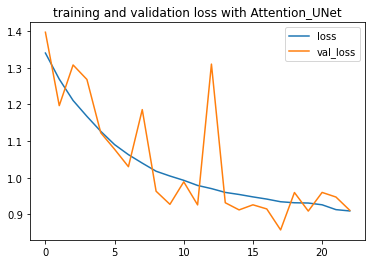

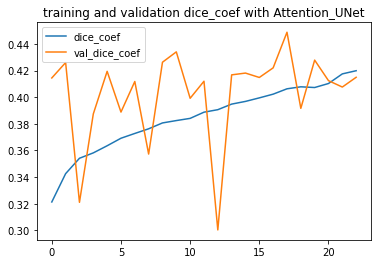

In [40]:
with open('history_Attention_UNet.json', 'w') as f:
    json.dump(str(history_Attention_UNet.history), f)

history_df = pd.DataFrame(history_Attention_UNet.history)
plt=history_df[['loss', 'val_loss']].plot()
plt.set_title("training and validation loss with Attention_UNet")
plt1=history_df[['dice_coef', 'val_dice_coef']].plot()
plt1.set_title("training and validation dice_coef with Attention_UNet")

### Sample of segemenation results with Attention Unet

In [77]:
#model.load_weights('model_0.h5')

batch_pred_masks = Attention_UNet.predict(
    check_generator, 
    workers=1,
    verbose=1
)

2/2 [==============================] - 0s 228ms/step


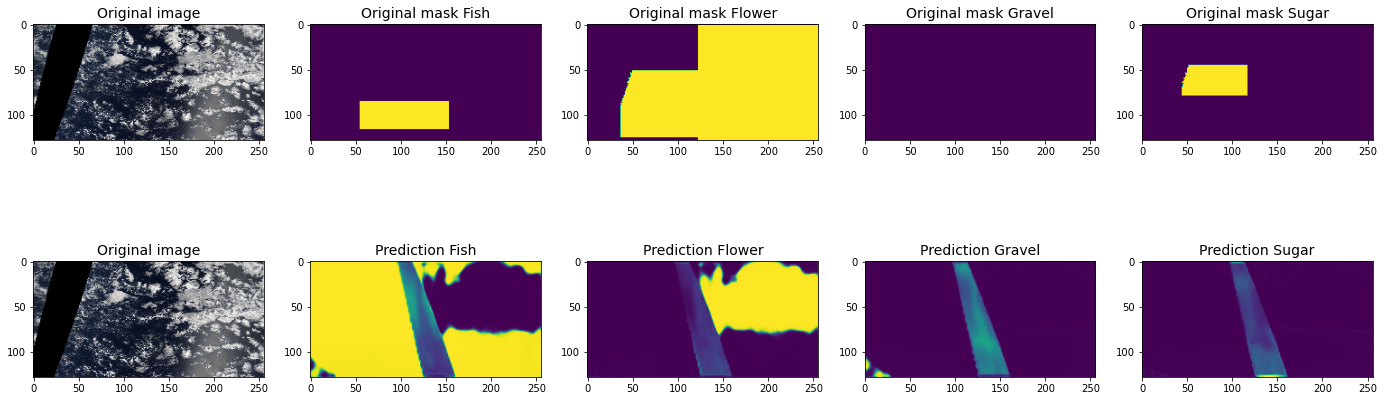

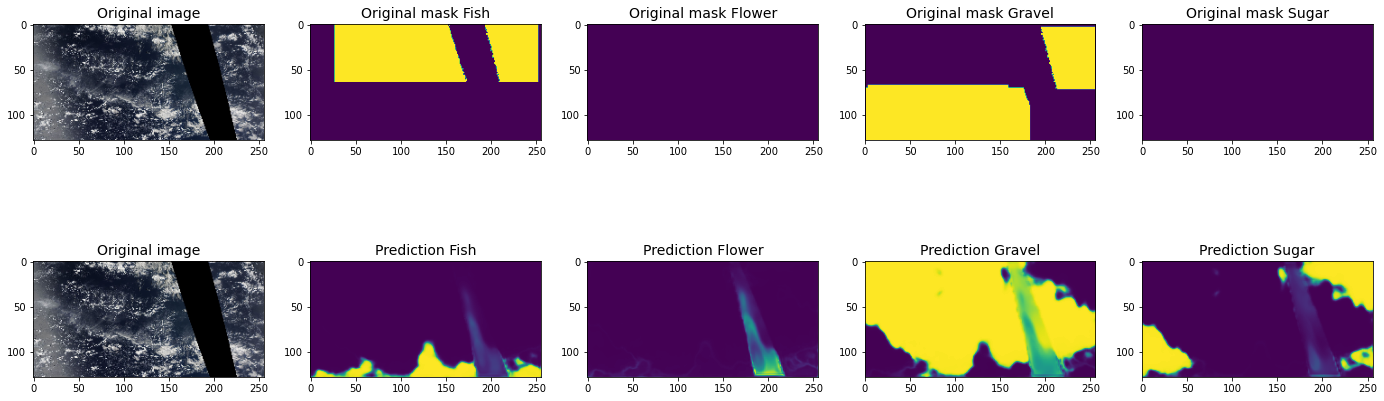

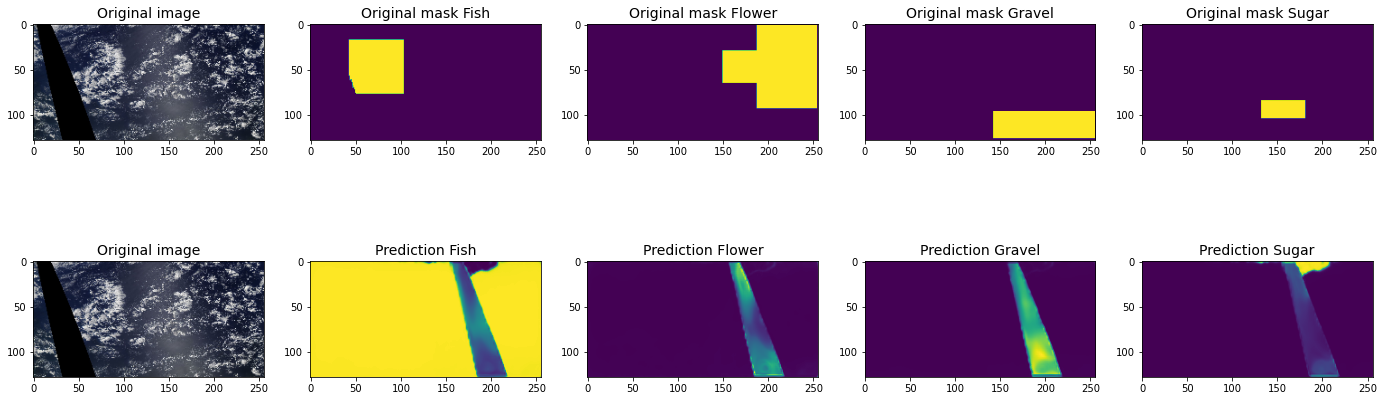

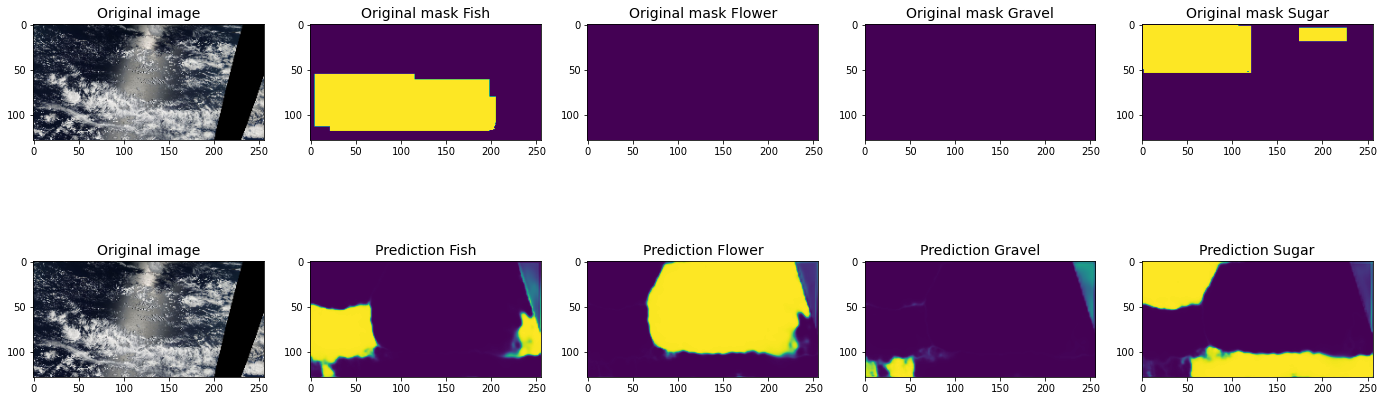

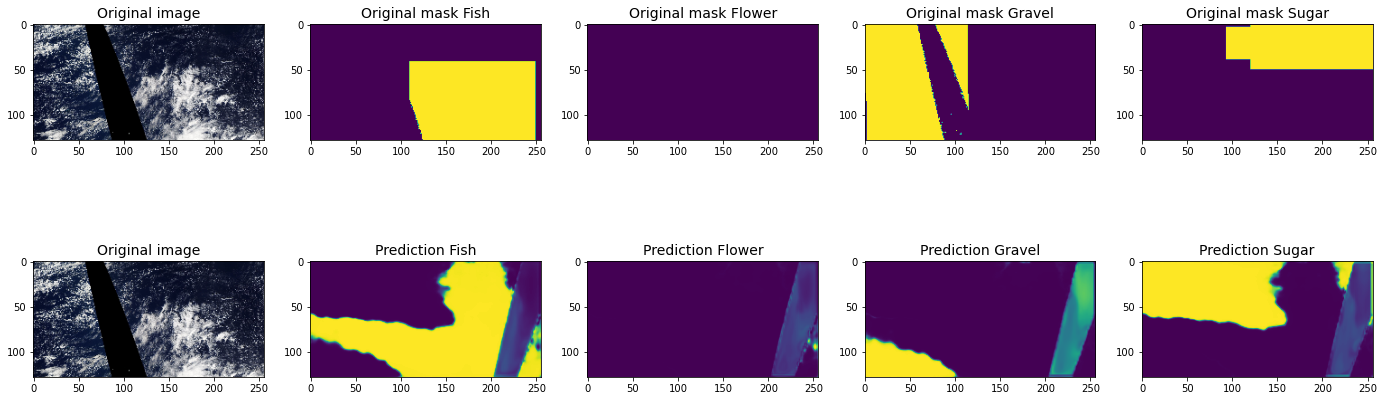

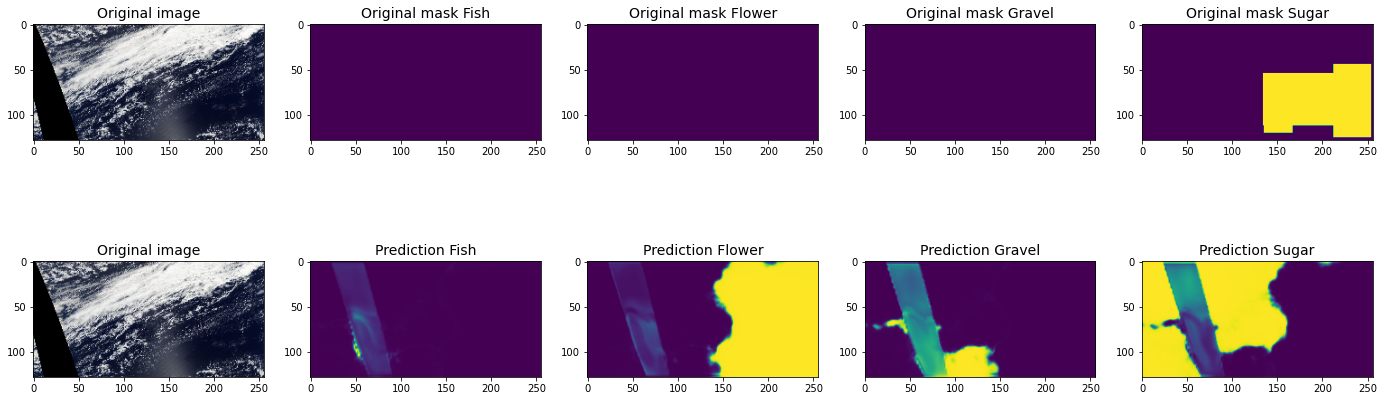

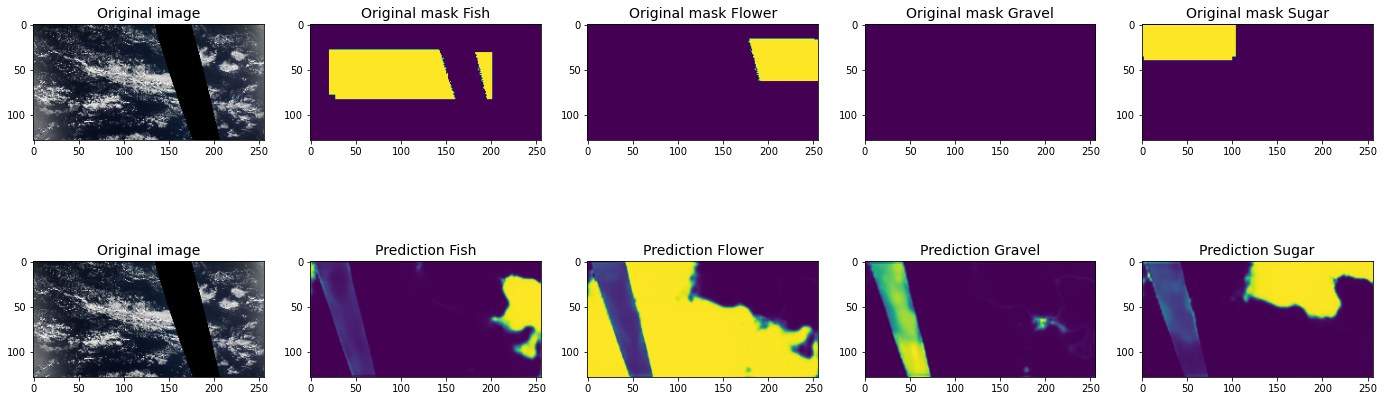

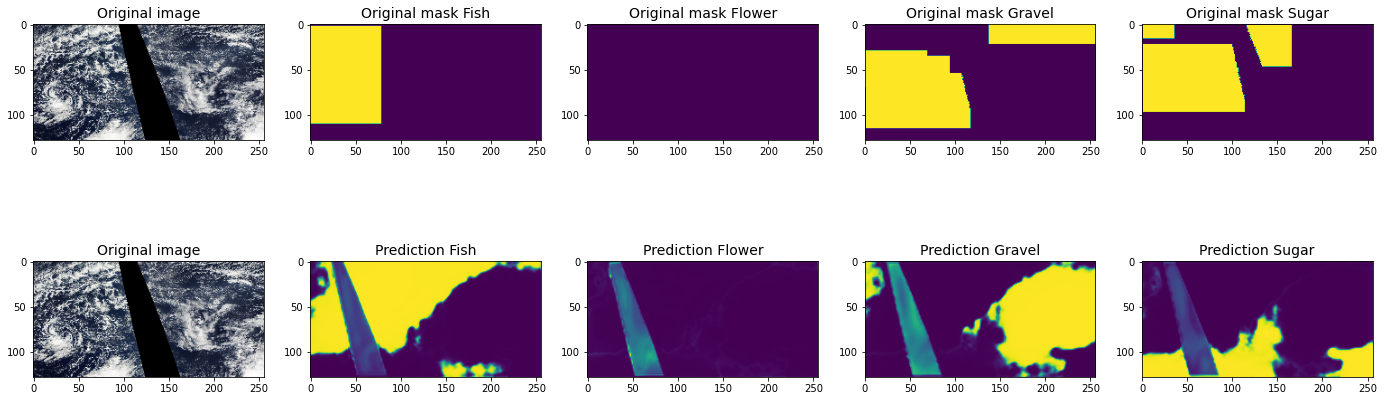

In [78]:
for i in range(8):
    visualize(val_generator.getitem(i)[0][0,:,:,:],val_generator.getitem(i)[1][0,:,:,:],batch_pred_masks[i])

### Attention_UNet evaluation with IoU as evaluation metrices

In [42]:
Attention_UNet.compile(optimizer=RAdam(learning_rate=0.0002), loss=[jacard_coef_loss], metrics=[jacard_coef])
Attention_UNet.summary()

Model: "Attention_UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 256, 64) 0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [43]:
%%time
#checkpoint = ModelCheckpoint('model_0EFU7.h5', save_best_only=True)

history_Attention_UNet1 = Attention_UNet.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, es, rlrop],
    epochs=30
)

Epoch 1/30
1109/1109 [==============================] - 550s 483ms/step - loss: -0.2723 - jacard_coef: 0.2723 - val_loss: -0.2920 - val_jacard_coef: 0.2920
Epoch 2/30
1109/1109 [==============================] - 523s 471ms/step - loss: -0.2763 - jacard_coef: 0.2763 - val_loss: -0.2961 - val_jacard_coef: 0.2961
Epoch 3/30
1109/1109 [==============================] - 532s 480ms/step - loss: -0.2790 - jacard_coef: 0.2790 - val_loss: -0.2542 - val_jacard_coef: 0.2542
Epoch 4/30
1109/1109 [==============================] - 533s 480ms/step - loss: -0.2830 - jacard_coef: 0.2830 - val_loss: -0.2869 - val_jacard_coef: 0.2869
Epoch 5/30
1109/1109 [==============================] - 530s 477ms/step - loss: -0.2862 - jacard_coef: 0.2862 - val_loss: -0.2905 - val_jacard_coef: 0.2905

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Epoch 6/30
1109/1109 [==============================] - 530s 478ms/step - loss: -0.2940 - jacard_coef: 0.2940 - val_loss: -0.3186 - val_jac

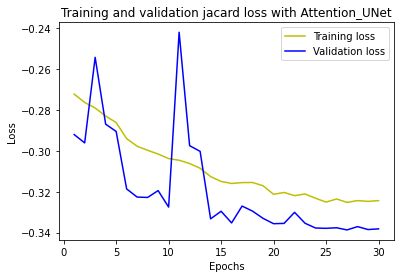

In [58]:
from matplotlib import pyplot as plt
loss = history_Attention_UNet1.history['loss']
val_loss = history_Attention_UNet1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation jacard loss with Attention_UNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

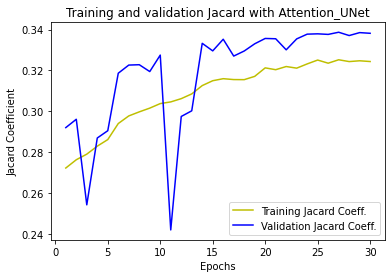

In [57]:
from matplotlib import pyplot as plt
jc = history_Attention_UNet1.history['jacard_coef']
#acc = history.history['accuracy']
val_jc = history_Attention_UNet1.history['val_jacard_coef']
#val_acc = history.history['val_accuracy']
#epochs = range(1, len(loss) + 1)

plt.plot(epochs, jc, 'y', label='Training Jacard Coeff.')
plt.plot(epochs, val_jc, 'b', label='Validation Jacard Coeff.')
plt.title('Training and validation Jacard with Attention_UNet')
plt.xlabel('Epochs')
plt.ylabel('Jacard Coefficient')
plt.legend()
plt.show()

## compile and train Residual_Attention_Unet

In [45]:
Attention_ResUNet = Attention_ResUNet(input_shape, NUM_CLASSES=4, dropout_rate=0.0, batch_norm=True)
Attention_ResUNet.summary()

Model: "AttentionResUNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 128, 256, 64) 256         conv2d_39[0][0]                  
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 128, 256, 64) 0           batch_normalization_27[0][0]     
___________________________________________________________________________________

In [47]:
checkpoint = ModelCheckpoint('Attention_ResUNet.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=ES_PATIENCE,
                   restore_best_weights=True,
                   verbose=1)

rlrop = ReduceLROnPlateau(monitor='val_loss',
                          mode='min',
                          patience=RLROP_PATIENCE,
                          factor=DECAY_DROP,
                          min_lr=1e-6,
                          verbose=1)

Attention_ResUNet.compile(optimizer=RAdam(learning_rate=0.0002), loss=bce_dice_loss, metrics=[dice_coef])
Attention_ResUNet.summary()

Model: "AttentionResUNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 128, 256, 64) 256         conv2d_39[0][0]                  
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 128, 256, 64) 0           batch_normalization_27[0][0]     
___________________________________________________________________________________

In [48]:
%%time
#checkpoint = ModelCheckpoint('model_0EFU7.h5', save_best_only=True)

history_Attention_ResUNet = Attention_ResUNet.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, es, rlrop],
    epochs=30
)

Epoch 1/30
1109/1109 [==============================] - 600s 523ms/step - loss: 1.3351 - dice_coef: 0.3227 - val_loss: 1.3087 - val_dice_coef: 0.4003
Epoch 2/30
1109/1109 [==============================] - 582s 524ms/step - loss: 1.2586 - dice_coef: 0.3474 - val_loss: 1.2598 - val_dice_coef: 0.3940
Epoch 3/30
1109/1109 [==============================] - 582s 525ms/step - loss: 1.2045 - dice_coef: 0.3570 - val_loss: 1.1766 - val_dice_coef: 0.3615
Epoch 4/30
1109/1109 [==============================] - 583s 526ms/step - loss: 1.1558 - dice_coef: 0.3647 - val_loss: 1.0873 - val_dice_coef: 0.4037
Epoch 5/30
1109/1109 [==============================] - 576s 520ms/step - loss: 1.1176 - dice_coef: 0.3695 - val_loss: 1.1224 - val_dice_coef: 0.3674
Epoch 6/30
1109/1109 [==============================] - 578s 521ms/step - loss: 1.0799 - dice_coef: 0.3763 - val_loss: 1.3294 - val_dice_coef: 0.2927
Epoch 7/30
1109/1109 [==============================] - 583s 525ms/step - loss: 1.0520 - dice_coef: 

Text(0.5, 1.0, 'training and validation dice_coef with Attention_ResUNet')

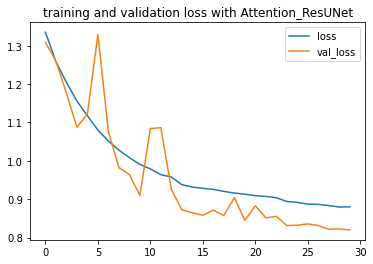

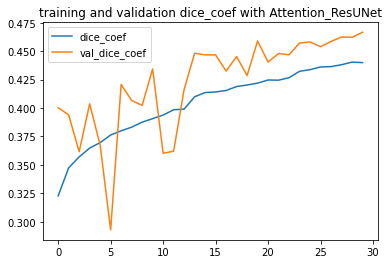

In [51]:
with open('history_Attention_ResUNet.json', 'w') as f:
    json.dump(str(history_Attention_ResUNet.history), f)

history_df = pd.DataFrame(history_Attention_ResUNet.history)
plt=history_df[['loss', 'val_loss']].plot()
plt.set_title("training and validation loss with Attention_ResUNet")
plt1=history_df[['dice_coef', 'val_dice_coef']].plot()
plt1.set_title("training and validation dice_coef with Attention_ResUNet")

### Residual_Attention_Unet evaluation with IoU as evaluation metrices

In [49]:
Attention_ResUNet.compile(optimizer=RAdam(learning_rate=0.0002), loss=[jacard_coef_loss], metrics=[jacard_coef])
Attention_ResUNet.summary()

Model: "AttentionResUNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 128, 256, 64) 256         conv2d_39[0][0]                  
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 128, 256, 64) 0           batch_normalization_27[0][0]     
___________________________________________________________________________________

In [50]:
%%time
#checkpoint = ModelCheckpoint('model_0EFU7.h5', save_best_only=True)

history_Attention_ResUNet1 = Attention_ResUNet.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, es, rlrop],
    epochs=30
)

Epoch 1/30
1109/1109 [==============================] - 599s 522ms/step - loss: -0.2916 - jacard_coef: 0.2916 - val_loss: -0.3112 - val_jacard_coef: 0.3112
Epoch 2/30
1109/1109 [==============================] - 578s 521ms/step - loss: -0.2898 - jacard_coef: 0.2898 - val_loss: -0.2760 - val_jacard_coef: 0.2760
Epoch 3/30
1109/1109 [==============================] - 579s 522ms/step - loss: -0.2933 - jacard_coef: 0.2933 - val_loss: -0.2550 - val_jacard_coef: 0.2550
Epoch 4/30
1109/1109 [==============================] - 579s 522ms/step - loss: -0.2948 - jacard_coef: 0.2948 - val_loss: -0.3168 - val_jacard_coef: 0.3168
Epoch 5/30
1109/1109 [==============================] - 578s 521ms/step - loss: -0.2960 - jacard_coef: 0.2960 - val_loss: -0.3184 - val_jacard_coef: 0.3184
Epoch 6/30
1109/1109 [==============================] - 578s 521ms/step - loss: -0.2996 - jacard_coef: 0.2996 - val_loss: -0.3040 - val_jacard_coef: 0.3040
Epoch 7/30
1109/1109 [==============================] - 579s 522

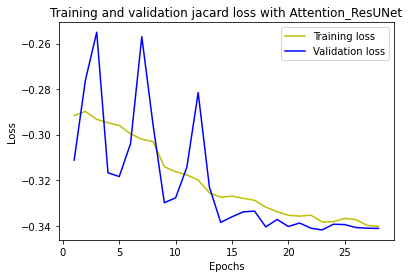

In [61]:
from matplotlib import pyplot as plt
loss = history_Attention_ResUNet1.history['loss']
val_loss = history_Attention_ResUNet1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation jacard loss with Attention_ResUNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

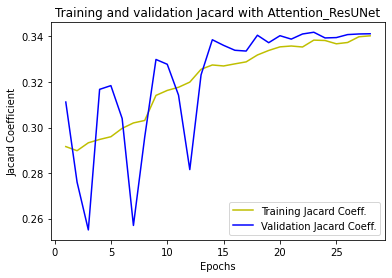

In [60]:
from matplotlib import pyplot as plt
jc = history_Attention_ResUNet1.history['jacard_coef']
#acc = history.history['accuracy']
val_jc = history_Attention_ResUNet1.history['val_jacard_coef']
#val_acc = history.history['val_accuracy']
#epochs = range(1, len(loss) + 1)

plt.plot(epochs, jc, 'y', label='Training Jacard Coeff.')
plt.plot(epochs, val_jc, 'b', label='Validation Jacard Coeff.')
plt.title('Training and validation Jacard with Attention_ResUNet')
plt.xlabel('Epochs')
plt.ylabel('Jacard Coefficient')
plt.legend()
plt.show()

### Smaple of segemenation results with Residual Attention Unet

In [79]:
#model.load_weights('model_0.h5')

batch_pred_masks = Attention_ResUNet.predict(
    check_generator, 
    workers=1,
    verbose=1
)

2/2 [==============================] - 0s 233ms/step


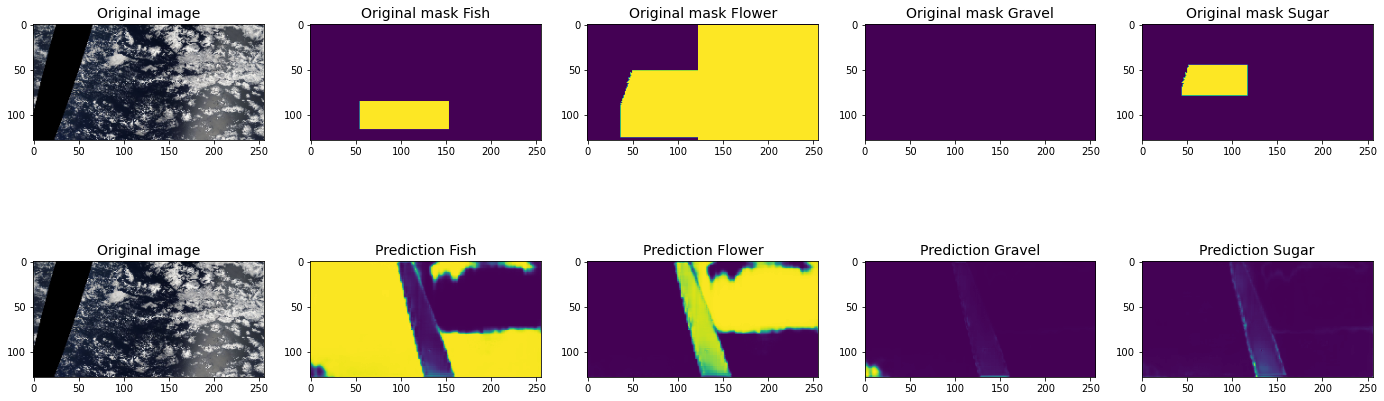

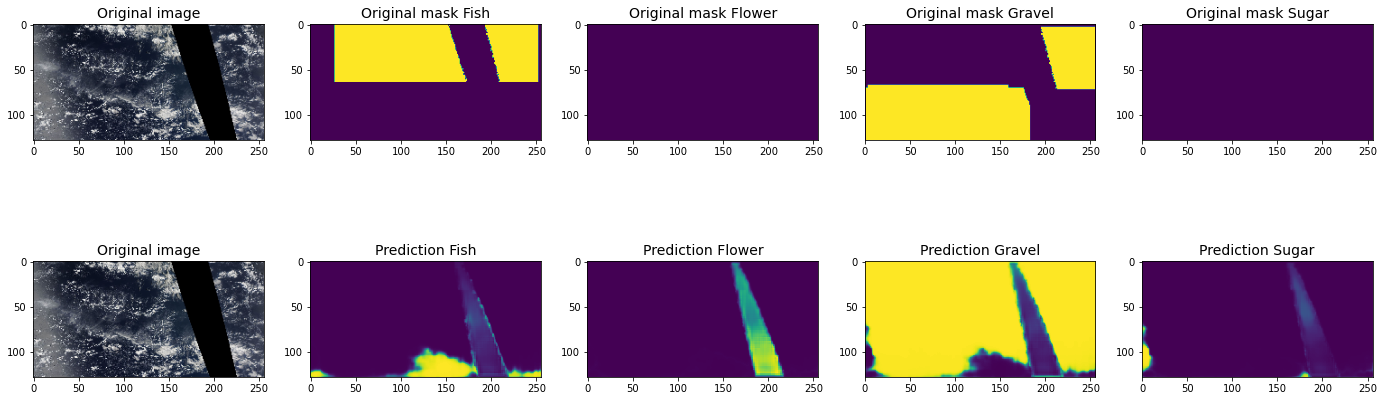

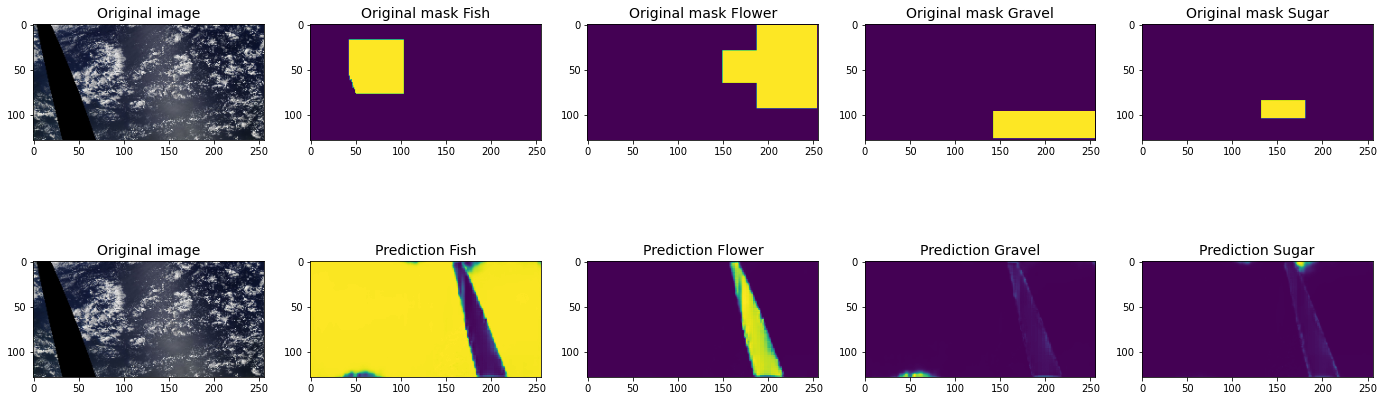

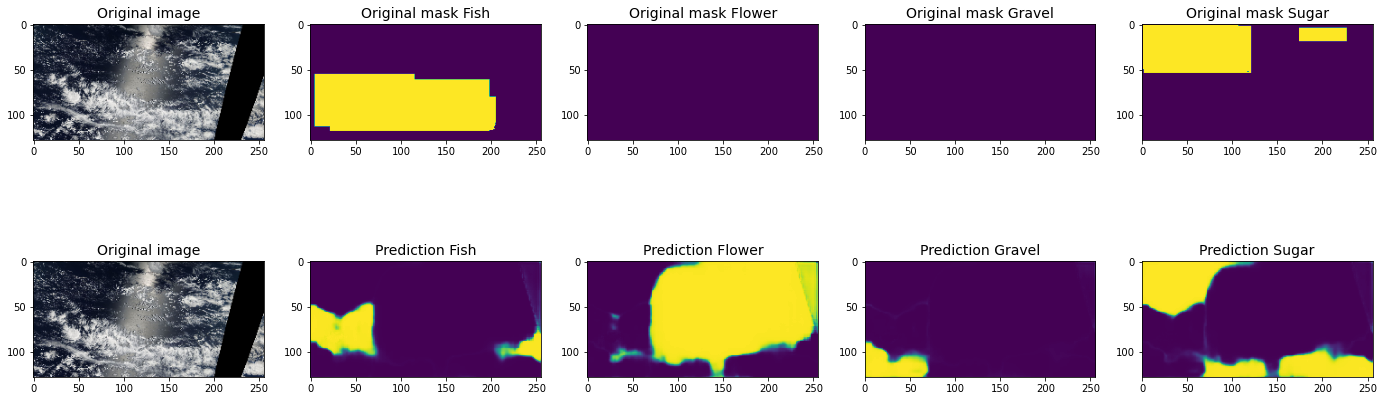

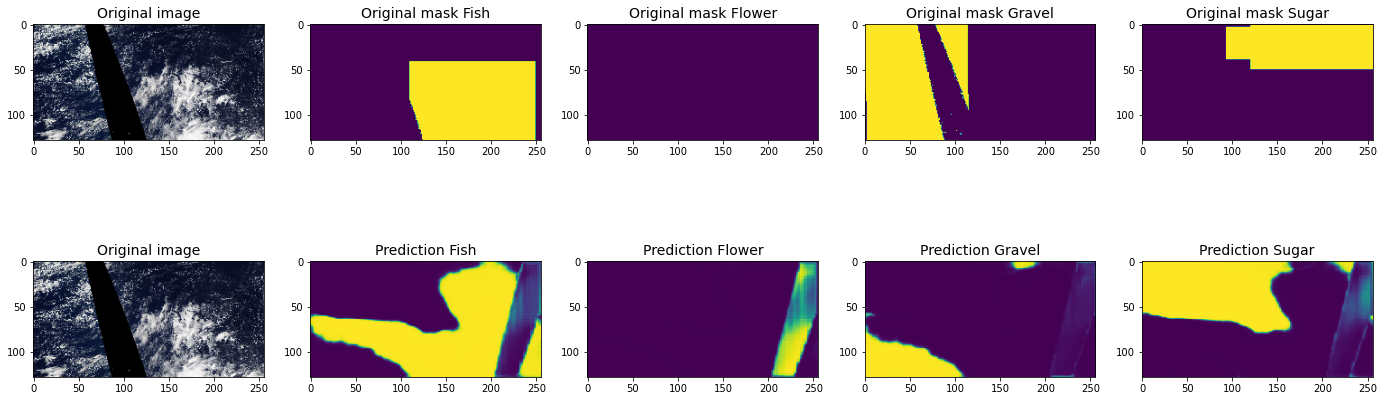

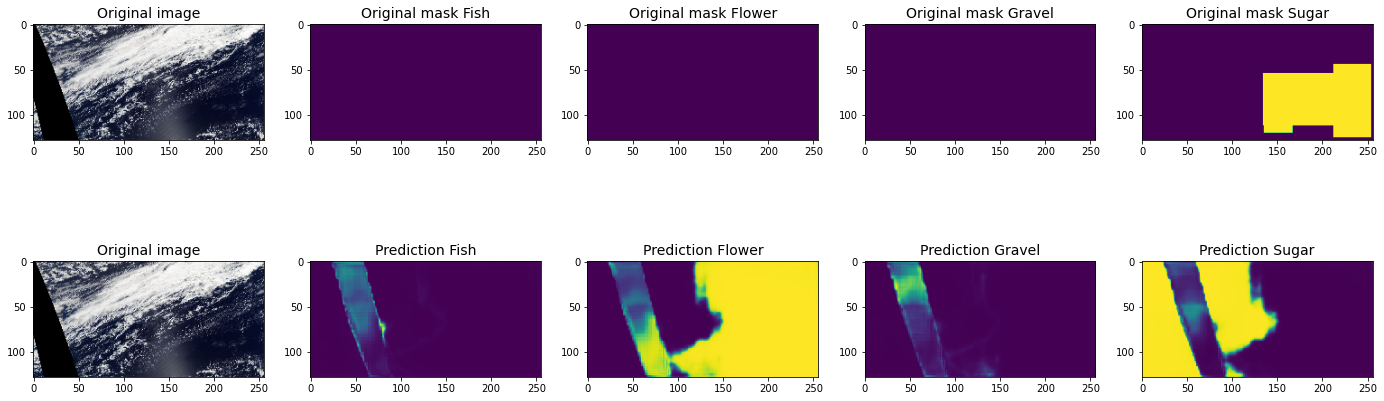

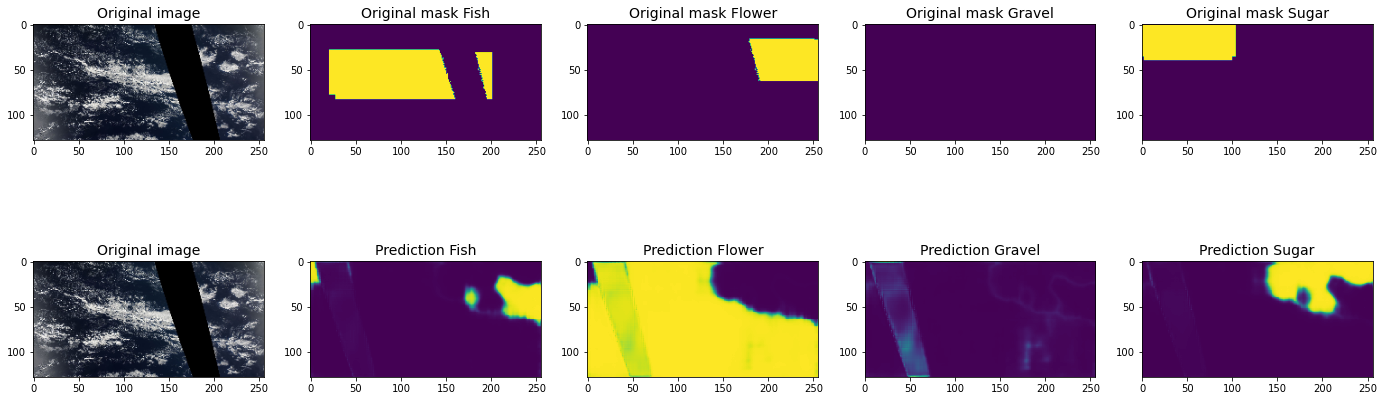

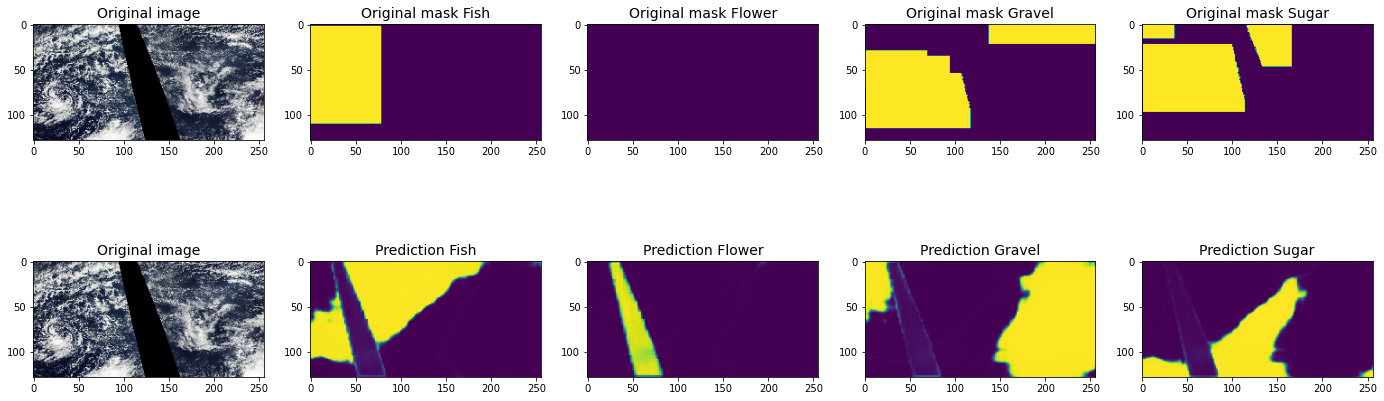

In [80]:
from matplotlib import pyplot as plt
for i in range(8):
    visualize(val_generator.getitem(i)[0][0,:,:,:],val_generator.getitem(i)[1][0,:,:,:],batch_pred_masks[i])